In [1]:
from __future__ import print_function

import sys
sys.path.append('../../src/utils')

from almaDatabaseQuery import *

import matplotlib.pyplot as plt
import numpy as np

plt.xkcd()

%matplotlib inline

### New function to make a list and to select calibrator

I add a function to retrieve all the flux from the ALMA Calibrator list with its frequency and observing date, and to retrieve redshift (z) from NED.

In [2]:
file_listcal = "alma_sourcecat_searchresults_20180419.csv"

In [3]:
q = databaseQuery()

#### Example, retrieve all the calibrator with a flux > 0.1 Jy:

In [4]:
listcal = q.read_calibratorlist(file_listcal, fluxrange=[0.1, 999999])

In [5]:
len(listcal)

1673

In [6]:
print("Name: ", listcal[0][0])
print("J2000 RA, dec: ", listcal[0][1], listcal[0][2])
print("Alias: ", listcal[0][3])
print("Flux density: ", listcal[0][4])
print("Band: ", listcal[0][5])
print("Freq: ", listcal[0][6])
print("Obs date: ", listcal[0][4])

Name:  J2253+1608
J2000 RA, dec:  343.49061641666657 16.14821136111111
Alias:  ['J2253+1608', 'J2253+161', 'J225358+160853', '3C454.3', 'B2251+158']
Flux density:  [5.72, 13.78, 14.47, 8.73, 3.579]
Band:  ['7', '3', '3', '6', '9']
Freq:  [337460000000.0, 103490000000.0, 91460000000.0, 233000000000.0, 673000000000.0]
Obs date:  [5.72, 13.78, 14.47, 8.73, 3.579]


#### Select all calibrators that heve been observed at least in 3 Bands [ >60s in B3, B6, B7]

- already queried and convert it to SQL
- exclude Cycle 0, array 12m

In [7]:
report, resume = q.select_object_from_sqldb("calibrators_brighterthan_0.1Jy_20180419.db", \
                                    maxFreqRes=999999999, array='12m', \
                                    excludeCycle0=True, \
                                    selectPol=False, \
                                    minTimeBand={3:60., 6:60., 7:60.}, \
                                    silent=True)

Number of accepted source:  186


We can write a "report file" or only use the "resume data", some will have redshift data retrieved from NED.

In [8]:
print("Name: ", resume[0][0])
print("From NED: ")
print("Name: ", resume[0][3])
print("J2000 RA, dec: ", resume[0][4], resume[0][5])
print("z: ", resume[0][6])
print("Total # of projects: ", resume[0][7])
print("Total # of UIDs: ", resume[0][8])
print("Gal lon: ", resume[0][9])
print("Gal lat: ", resume[0][10])

Name:  J2253+1608
From NED: 
Name:  3C 454.3
J2000 RA, dec:  343.49062 16.14821
z:  0.859
Total # of projects:  30
Total # of UIDs:  56
Gal lon:  86.11110391202152
Gal lat:  -38.1837784919047


Sometimes there is no redshift information found in NED

#### Retrieve object nonALMACAL and ALMACAL and combining data in resume and listcal

In [9]:
report_non, resume_non = q.select_object_from_sqldb("calibrators_brighterthan_0.1Jy_20180419.db", \
                                    maxFreqRes=999999999, array='12m', \
                                    excludeCycle0=True, \
                                    selectPol=False, \
                                    minTimeBand={3:60., 6:60., 7:60.}, \
                                    nonALMACAL = True, \
                                    silent=True)

Number of accepted source:  134


In [10]:
report_almacal, resume_almacal = q.select_object_from_sqldb("calibrators_brighterthan_0.1Jy_20180419.db", \
                                    maxFreqRes=999999999, array='12m', \
                                    excludeCycle0=True, \
                                    selectPol=False, \
                                    minTimeBand={3:60., 6:60., 7:60.}, \
                                    onlyALMACAL = True, \
                                    silent=True)

Number of accepted source:  52


In [11]:
for i, obj in enumerate(resume):
    for j, cal in enumerate(listcal):
        if obj[0] == cal[0]: # same name
            obj.append(cal[4:]) # add [flux, band, flux obsdate] in the "resume"

for i, obj in enumerate(resume_non):
    for j, cal in enumerate(listcal):
        if obj[0] == cal[0]: # same name
            obj.append(cal[4:]) # add [flux, band, flux obsdate] in the "resume"

for i, obj in enumerate(resume_almacal):
    for j, cal in enumerate(listcal):
        if obj[0] == cal[0]: # same name
            obj.append(cal[4:]) # add [flux, band, flux obsdate] in the "resume"

### Select objects which has redshift
- collect the flux, band, freq, and obsdate
- plot based on the Band

In [12]:
def collect_z_and_flux(Band, resume_array):
    z = []
    flux = []
    for idata in resume_array:
        if idata[6] is not None: # select object which has redshift information
            fluxnya = idata[-1][0]
            bandnya = idata[-1][1]
            freqnya = idata[-1][2]
            datenya  = idata[-1][3]
            for i, band in enumerate(bandnya):
                if band == str(Band): # take only first data
                    flux.append(fluxnya[i])
                    z.append(idata[6])
                    break
                    
    return z, flux

In [13]:
z3, f3 = collect_z_and_flux(3, resume)
print("Number of seleted source in B3: ", len(z3))
z6, f6 = collect_z_and_flux(6, resume)
print("Number of seleted source in B6: ", len(z6))
z7, f7 = collect_z_and_flux(7, resume)
print("Number of seleted source in B7: ", len(z7))

Number of seleted source in B3:  146
Number of seleted source in B6:  113
Number of seleted source in B7:  122


In [14]:
znon3, fnon3 = collect_z_and_flux(3, resume_non)
print("Number of seleted source in B3: ", len(znon3))
znon6, fnon6 = collect_z_and_flux(6, resume_non)
print("Number of seleted source in B6: ", len(znon6))
znon7, fnon7 = collect_z_and_flux(7, resume_non)
print("Number of seleted source in B7: ", len(znon7))

Number of seleted source in B3:  99
Number of seleted source in B6:  69
Number of seleted source in B7:  78


In [15]:
zalm3, falm3 = collect_z_and_flux(3, resume_almacal)
print("Number of seleted source in B3: ", len(zalm3))
zalm6, falm6 = collect_z_and_flux(6, resume_almacal)
print("Number of seleted source in B6: ", len(zalm6))
zalm7, falm7 = collect_z_and_flux(7, resume_almacal)
print("Number of seleted source in B7: ", len(zalm7))

Number of seleted source in B3:  47
Number of seleted source in B6:  44
Number of seleted source in B7:  44


### Plot Flux vs Redshift, NonALMACAL vs ALMACAL

- same object will located in the same z
- some of them will not have flux in all 3 bands.
- nonALMACAL = red
- ALMACAL = blue

Text(0.5,1,'B7')

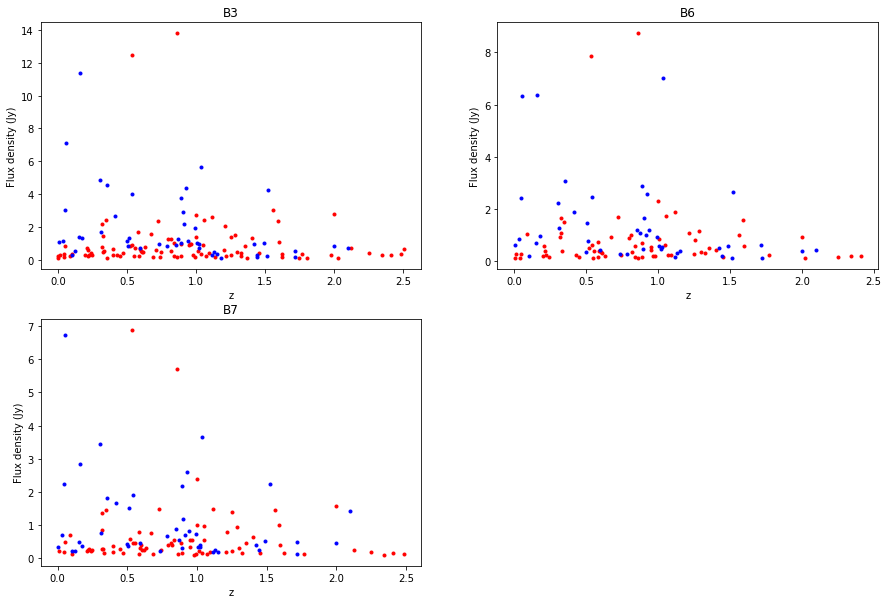

In [16]:
plt.figure(figsize=(15,10))

plt.subplot(221)
plt.plot(znon3, fnon3, 'r.', zalm3, falm3, 'b.')
plt.xlabel("z")
plt.ylabel("Flux density (Jy)")
plt.title("B3")

plt.subplot(222)
plt.plot(znon6, fnon6, 'r.', zalm6, falm6, 'b.')
plt.xlabel("z")
plt.ylabel("Flux density (Jy)")
plt.title("B6")

plt.subplot(223)
plt.plot(znon7, fnon7, 'r.', zalm7, falm7, 'b.')
plt.xlabel("z")
plt.ylabel("Flux density (Jy)")
plt.title("B7")

# plt.subplot(224)
# plt.plot(z3, f3, 'ro', z6, f6, 'go', z7, f7, 'bo', alpha=0.3)
# plt.xlabel("z")
# plt.ylabel("Flux density (Jy)")
# plt.title("B3, B6, B7")

### Distribution of redshift

only B3

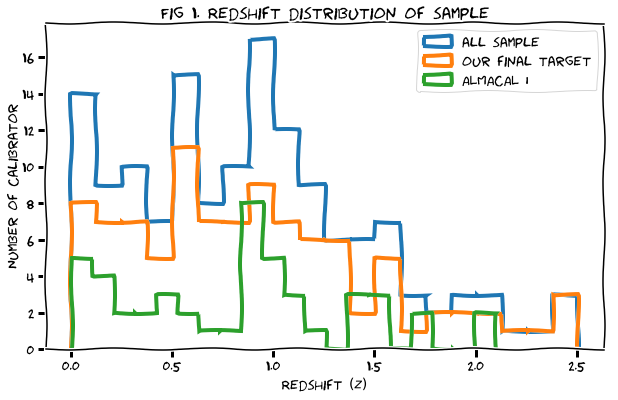

In [56]:
# from matplotlib import rcParams
# rcParams['font.family'] = ['Humor Sans', 'Comic Sans MS']
# rcParams['font.size'] = 14.0
# rcParams['axes.linewidth'] = 1.5
# rcParams['lines.linewidth'] = 2.0
# rcParams['figure.facecolor'] = 'white'
# rcParams['grid.linewidth'] = 0.0
# rcParams['axes.unicode_minus'] = False
# rcParams['xtick.major.size'] = 8
# rcParams['xtick.major.width'] = 3
# rcParams['ytick.major.size'] = 8
# rcParams['ytick.major.width'] = 3

plt.xkcd()

plt.figure(figsize=(10,6))

#plt.subplot(121)
plt.hist(z3, bins=20, label="all sample", histtype="step", linewidth=4)
plt.hist(znon3, bins=20, label="our final target", histtype="step", linewidth=4)
plt.hist(zalm3, bins=20, label="ALMACAL I", histtype="step", linewidth=4)

plt.xlabel(r"Redshift $(z)$")
plt.ylabel("Number of Calibrator")
plt.title("Fig 1. Redshift distribution of sample")

plt.legend()

# plt.subplot(122)
# plt.hist(z3, bins=15, label="all", normed=True, cumulative=True, histtype='step')
# plt.hist(znon3, bins=15, label="nonALMACAL", normed=True, cumulative=True, histtype='step')
# plt.hist(zalm3, bins=15, label="ALMACAL", normed=True, cumulative=True, histtype='step')
# plt.legend()
# plt.xlabel(r"$z$")
# plt.ylabel("Normalized-Cumulative N")
# plt.show()

plt.savefig("sample_redshift.png", transparent=True, bbox_tight=True)

In [29]:
plt.title?

### Plot log(Luminosity) vs redshift, nonALMACAL vs ALMACAL

In [18]:
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Tcmb0=2.725)

How to calculate luminosity:

$$L_{\nu} (\nu_{e}) = \frac{4 \pi D_{L}^2}{1+z} \cdot S_{\nu} (\nu_{o})$$

Notes: 
- Calculate Luminosity or Power in a specific wavelength (without k-correction e.g. using spectral index)
- $L_{\nu}$ in watt/Hz, in emited freq
- $S_{\nu}$ in watt/m$^2$/Hz, in observed freq
- $D_L$ is luminosity distance, calculated using `astropy.cosmology` function
- need to calculate distance in meter
- need to convert Jy to watt/m$^2$/Hz ----- $\times 10^{-26}$

In [19]:
def calc_power(z, flux):
    """
    z = redshift
    flux in Jy
    """
    z = np.array(z)
    flux = np.array(flux)
    
    dL = cosmo.luminosity_distance(z).to(u.meter).value # Luminosity distance
    luminosity = 4.0*np.pi*dL*dL/(1.0+z) * flux * 1e-26
    
    return z, luminosity

#### Plot $\log_{10}(L)$ vs $z$

In [20]:
z3, l3 = calc_power(z3, f3)
z6, l6 = calc_power(z6, f6)
z7, l7 = calc_power(z7, f7)

znon3, lnon3 = calc_power(znon3, fnon3)
znon6, lnon6 = calc_power(znon6, fnon6)
znon7, lnon7 = calc_power(znon7, fnon7)

zalm3, lalm3 = calc_power(zalm3, falm3)
zalm6, lalm6 = calc_power(zalm6, falm6)
zalm7, lalm7 = calc_power(zalm7, falm7)

zdummy = np.linspace(0.001, 2.5, 100)
fdummy = 0.1 # Jy, our cut threshold
zdummy, Ldummy0 = calc_power(zdummy, fdummy)
zdummy, Ldummy3 = calc_power(zdummy, np.max(f3))
zdummy, Ldummy6 = calc_power(zdummy, np.max(f6))
zdummy, Ldummy7 = calc_power(zdummy, np.max(f7))

Text(0.5,1,'B7')

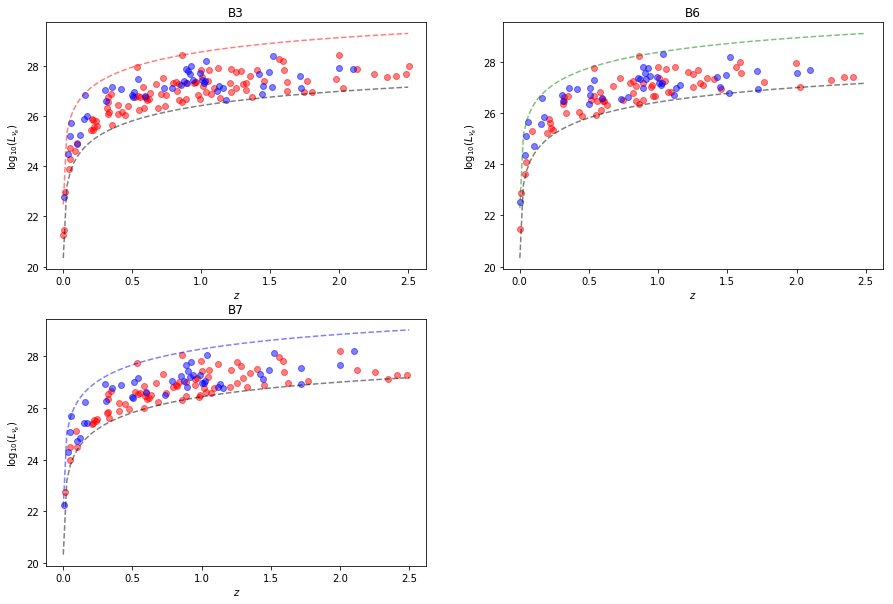

In [21]:
plt.figure(figsize=(15,10))

plt.subplot(221)
plt.plot(znon3, np.log10(lnon3), 'ro', zalm3, np.log10(lalm3), 'bo', \
         zdummy, np.log10(Ldummy0), 'k--', zdummy, np.log10(Ldummy3), 'r--', alpha=0.5)
plt.xlabel(r"$z$"); plt.ylabel(r"$\log_{10}(L_{\nu_e})$"); plt.title("B3")

plt.subplot(222)
plt.plot(znon6, np.log10(lnon6), 'ro', zalm6, np.log10(lalm6), 'bo', \
         zdummy, np.log10(Ldummy0), 'k--', zdummy, np.log10(Ldummy6), 'g--', alpha=0.5)
plt.xlabel(r"$z$"); plt.ylabel(r"$\log_{10}(L_{\nu_e})$"); plt.title("B6")

plt.subplot(223)
plt.plot(znon7, np.log10(lnon7), 'ro', zalm7, np.log10(lalm7), 'bo', \
         zdummy, np.log10(Ldummy0), 'k--', zdummy, np.log10(Ldummy7), 'b--', alpha=0.5)
plt.xlabel(r"$z$"); plt.ylabel(r"$\log_{10}(L_{\nu_e})$"); plt.title("B7")

# plt.subplot(224)
# plt.plot(znon3, np.log10(lnon3), 'r*', znon6, np.log10(lnon6), 'g*', znon7, np.log10(lnon7), 'b*', \
#          zdummy, np.log10(Ldummy0), 'k--', \
#          zdummy, np.log10(Ldummy3), 'r--', \
#          zdummy, np.log10(Ldummy6), 'g--', \
#          zdummy, np.log10(Ldummy7), 'b--', alpha=0.5)
# plt.xlabel(r"$z$"); plt.ylabel(r"$\log_{10}(L_{\nu_e})$"); plt.title("B3, B6, B7")

Black-dashed line are for 0.1 Jy flux.

### Distribution for Luminosity

Only Band 3

/scratch/home/rwibowo/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


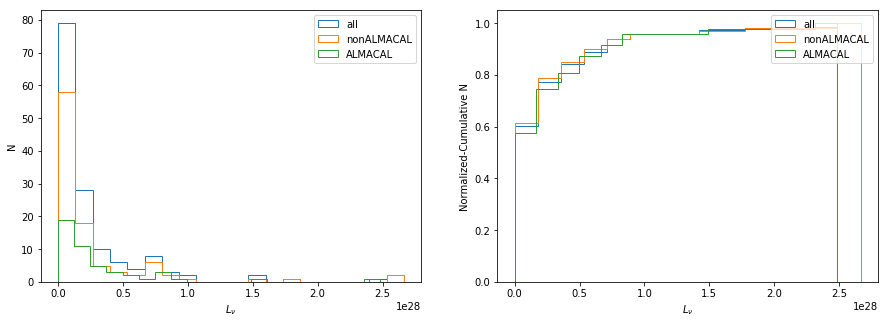

In [22]:
plt.figure(figsize=(15,5))

plt.subplot(121)
plt.hist(l3, bins=20, label="all", histtype="step")
plt.hist(lnon3, bins=20, label="nonALMACAL", histtype="step")
plt.hist(lalm3, bins=20, label="ALMACAL", histtype="step")
plt.legend()
plt.xlabel(r"$L_{\nu}$")
plt.ylabel("N")

plt.subplot(122)
plt.hist(l3, bins=15, label="all", normed=True, cumulative=True, histtype='step')
plt.hist(lnon3, bins=15, label="nonALMACAL", normed=True, cumulative=True, histtype='step')
plt.hist(lalm3, bins=15, label="ALMACAL", normed=True, cumulative=True, histtype='step')
plt.legend()
plt.xlabel(r"$L_{\nu}$")
plt.ylabel("Normalized-Cumulative N")
plt.show()

In [23]:
from scipy.stats import ks_2samp

In [24]:
print(ks_2samp(z3, znon3))
print(ks_2samp(z3, zalm3))
print(ks_2samp(znon3, zalm3))

Ks_2sampResult(statistic=0.032447765324477684, pvalue=0.9999999539676505)
Ks_2sampResult(statistic=0.08190032060623725, pvalue=0.9641430561963702)
Ks_2sampResult(statistic=0.11068128089404684, pvalue=0.8069114113185069)


In [25]:
print(ks_2samp(l3, lnon3))
print(ks_2samp(l3, lalm3))
print(ks_2samp(lnon3, lalm3))

Ks_2sampResult(statistic=0.07319773073197738, pvalue=0.8989842786104661)
Ks_2sampResult(statistic=0.13290585835033514, pvalue=0.5265381571814292)
Ks_2sampResult(statistic=0.20610358908231252, pvalue=0.11647469385939158)


From this simple KS test:
- The "redshift" distribution of ALMACAL or NONALMACAL sample are similar/same (low KS-statistics, high p-value). 
- The luminosity distribution is a bit different, I think especially from the low luminosity sample.